In [1]:
import pandas as pd
import numpy as np
import keras
import sklearn
from sklearn.neural_network import MLPClassifier
import olac

from IPython import display

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Using TensorFlow backend.


# Load data

We're comparing online vs offline training. We're thus creating the same dataset but we want to run over it twice in the pipeline. To do this we run one of the generators, save it as a dataframe, so the data is consistent on both.

In [2]:
# --- define data generator
data = list(olac.data_generators.roving_balls(steps=2000))

online_data = olac.data_generators.delayed_generator(data.copy(), .1)
offline_data = olac.data_generators.delayed_generator(data.copy(), .1)

In [ ]:
# data = pd.read_csv("../test.csv", index_col=0)
# train = data.loc[:1000,:]
# test = data.loc[1001:,:]

In [ ]:
# plt.figure(figsize = (20,10))

# plt.subplot(121, title='All data points')
# plt.scatter(data.loc[data['label']==1,'x1'], data.loc[data['label']==1,'x2'], c='r', s=10)
# plt.scatter(data.loc[data['label']==0,'x1'], data.loc[data['label']==0,'x2'], c='b', s=10)

# plt.subplot(122, title='First 1000 rows')
# train = data.loc[:1000, :]
# plt.scatter(train.loc[train['label']==1,'x1'], train.loc[train['label']==1,'x2'], c='r', s=10)
# plt.scatter(train.loc[train['label']==0,'x1'], train.loc[train['label']==0,'x2'], c='b', s=10)

Save the dataset so we can reuse it later

# Models

In [3]:
# ---  define models
online_model = MLPClassifier((64, 32, ), learning_rate='adaptive', batch_size=1)
offline_model = MLPClassifier((64, 32, ), learning_rate='adaptive', solver='sgd')

In [4]:
labeller = olac.pipeline.ThresholdLabeller(threshold=20, prob=0.3, verbose=False)
onpredictor = olac.pipeline.OnlinePredictor(verbose=False)
offpredictor = olac.pipeline.OfflinePredictor(20, verbose=False)

pipeline_on = olac.pipeline.DemoPipeline(model=online_model, predictor=onpredictor,
                                         labeller=labeller, data_generator=online_data)
pipeline_off = olac.pipeline.DemoPipeline(model=offline_model, predictor=offpredictor,
                                         labeller=labeller, data_generator=offline_data)

In [5]:
eval_on, train_on = pipeline_on.demo('plot', describe=False, sleep=0.1)

PIPELINE END ---
Total time: 242.6


In [6]:
eval_off, train_off = pipeline_off.demo('plot', describe=False, sleep=2)

PIPELINE END ---
Total time: 308.08


## Instant replay

We can replay the pipeline plots after we've used the demo function, using `pipeline.replay()`. When running the demo_pipeline.demo() option, the predictions in the grid dyring trainign were saved and can be recalled again. 

NB: This only works if the demo pipeline+function was used, otherwise there are no predections being made on a grid, to speed up the process.

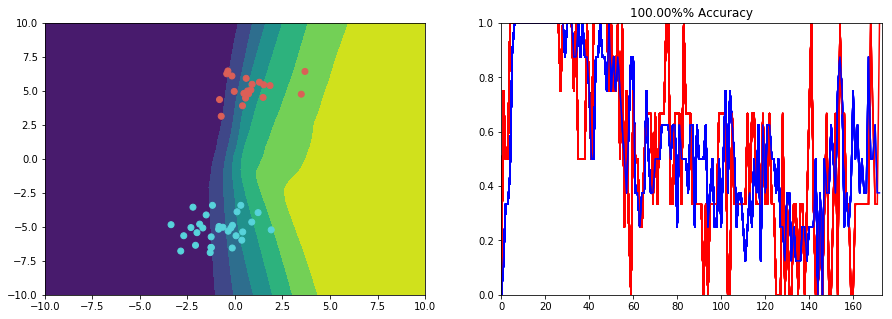

In [7]:
pipeline_on.replay(val_set=eval_on, train_set=train_on, x_min=-10, x_max=10)

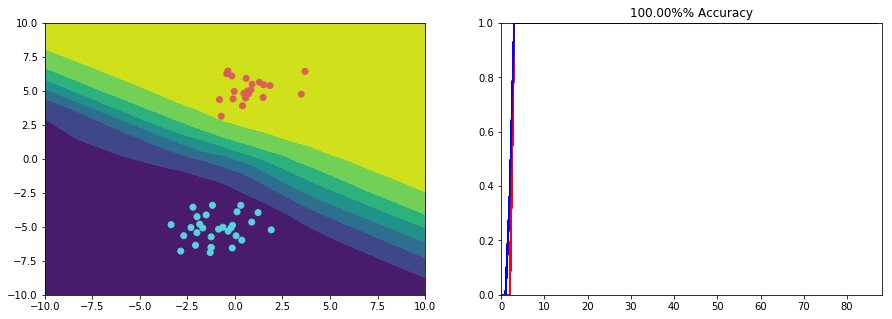

In [8]:
pipeline_off.replay(val_set=eval_off, train_set=train_off, x_max=10, x_min=-10)

## Performance
We can also check the historic performance of the model using the `performance` utility fucntion of the `vis` module. This will show the standard metrics for the eval and train set over the training time. 

The eval set is the 'visible' set, as in, the points we have labelled and can thus use to calculate the perforamnce. The train set is the 'invisible' set, i.e. the set we don't have the labels for. But since we are using a fake dataset we can actually take the generated labels to calculate the performance of this set as well. 

Ideally, we want the metrics for eval and train to be close, so we know the train set is a good indicator of the actual performance of the model.

### performance online

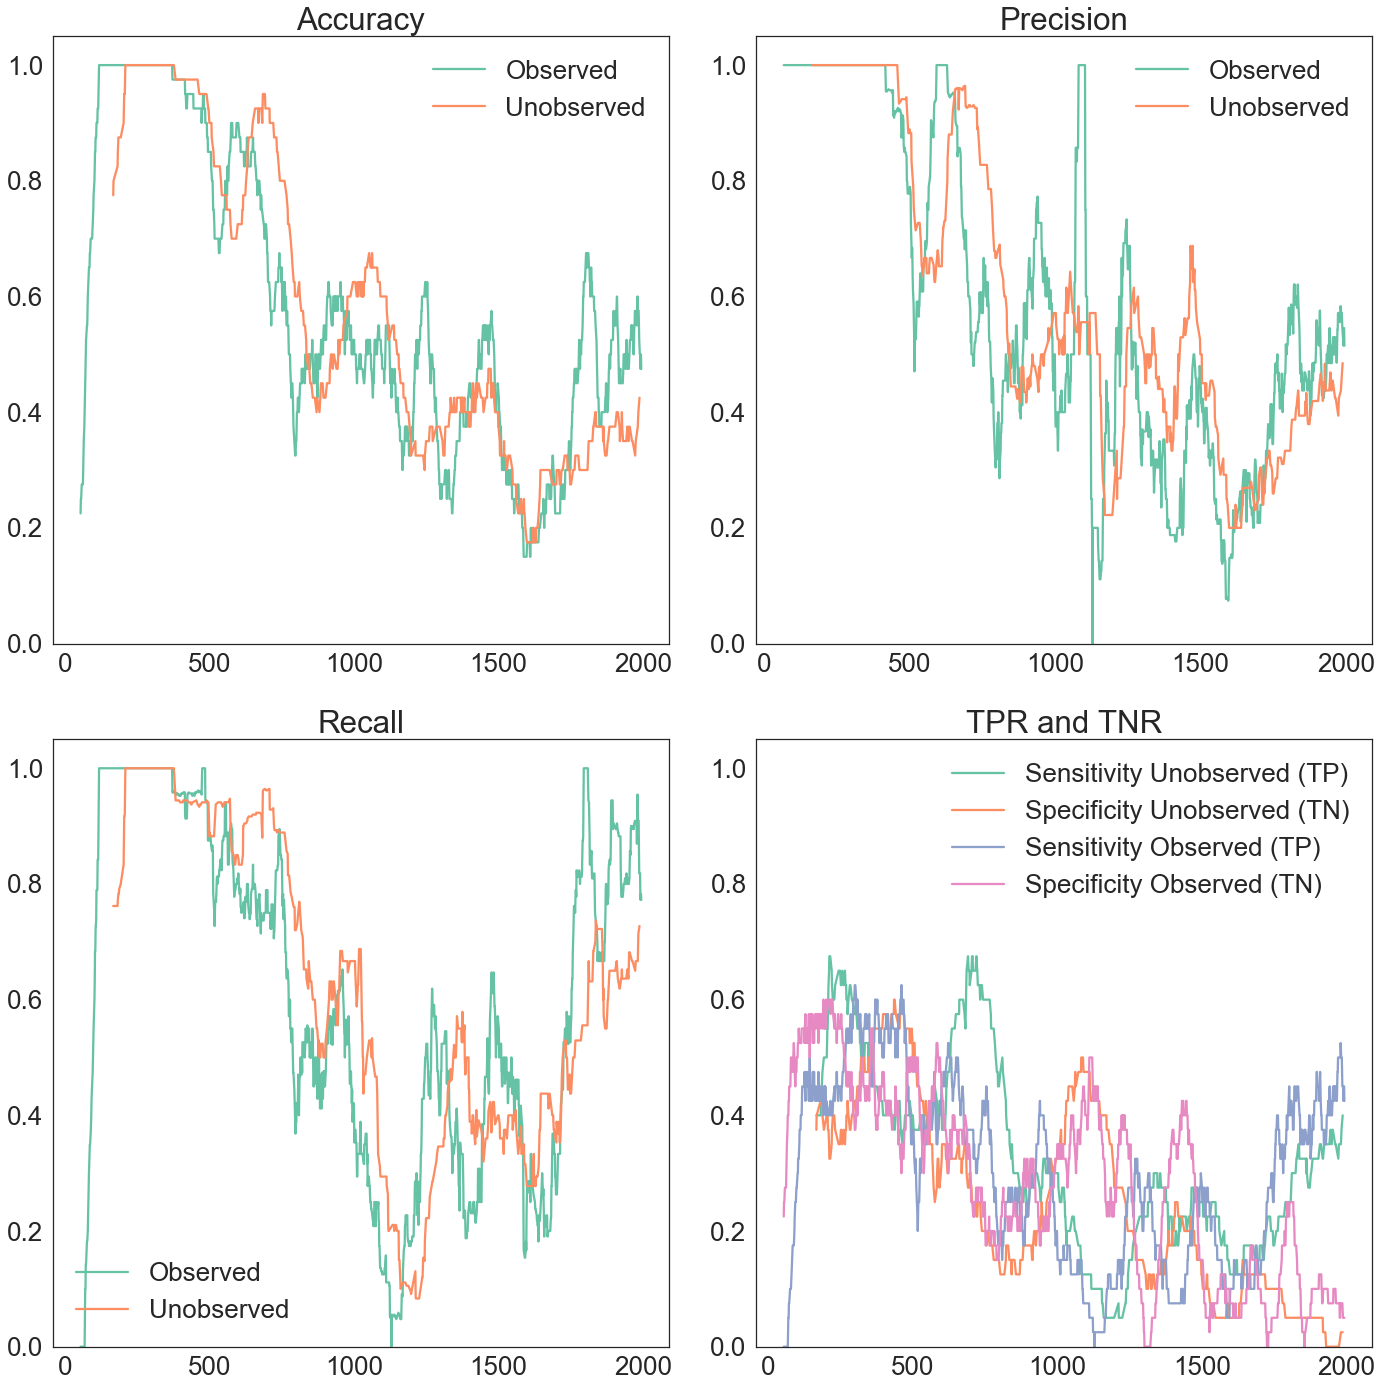

In [9]:
olac.vis.performance(eval_on, train_on, window=40)

### Performace offline

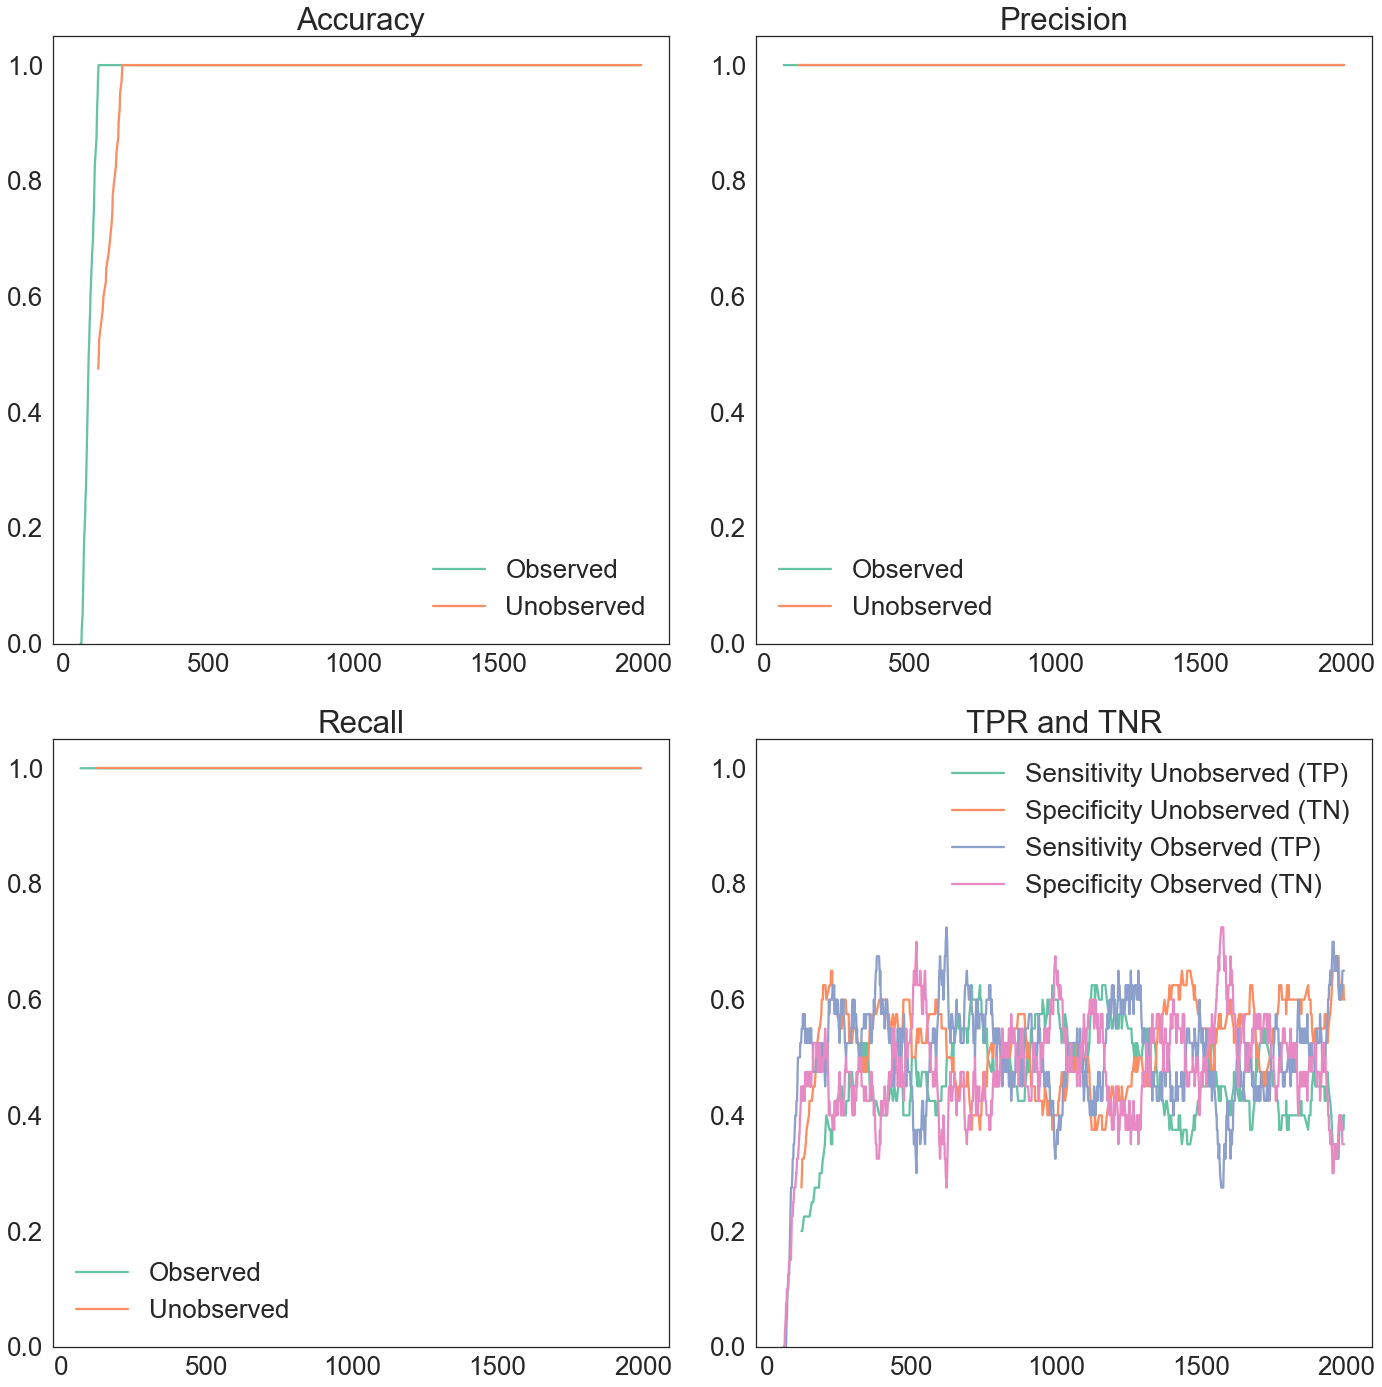

In [10]:
olac.vis.performance(eval_off, train_off, window=40)